In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [2]:
# Load the data
X_train = pd.read_csv('/content/drive/MyDrive/Data Mining Project/X_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Data Mining Project/y_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Data Mining Project/X_test.csv')

In [3]:
# Define the preprocessing pipeline
column_transformer = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), ['100g_USD']),  # Using MinMaxScaler to avoid negative values for Naive Bayes
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['roaster', 'roast', 'origin']),
        ('text', TfidfVectorizer(stop_words='english'), 'review')
    ], remainder='drop')  # 'remainder' parameter drops other columns not specified explicitly

In [4]:

def evaluate_configuration(features, X_train, y_train):
    # Define the ColumnTransformer for different subsets of features
    preprocessors = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), ['100g_USD'] if '100g_USD' in features else []),
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['roaster', 'roast', 'origin']),
            ('text', TfidfVectorizer(stop_words='english'), 'review' if 'review' in features else [])
        ], remainder='drop')

    # Create the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessors),
        ('classifier', MultinomialNB())
    ])

    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train['class'], cv=5, scoring='f1')

    # Return the mean and standard deviation of the F1 scores
    return cv_scores.mean(), cv_scores.std()


In [5]:
# Define the full pipeline with Naive Bayes classifier
naive_bayes_pipeline = Pipeline([
    ('preprocess', column_transformer),
    ('classifier', MultinomialNB())
])

# Train the model
naive_bayes_pipeline.fit(X_train, y_train['class'])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['100g_USD']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['roaster', 'roast',
                                                   'origin']),
                                                 ('text',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'review')])),
                ('classifier', MultinomialNB())])

In [6]:
# Perform 5-fold cross-validation and calculate F1 score
scores = cross_validate(naive_bayes_pipeline, X_train, y_train['class'], cv=5, scoring='f1', return_train_score=True)

In [7]:
# Extract and print training and validation scores
train_f1_scores = scores['train_score']
val_f1_scores = scores['test_score']
mean_train_f1 = train_f1_scores.mean()
std_train_f1 = train_f1_scores.std()
mean_val_f1 = val_f1_scores.mean()
std_val_f1 = val_f1_scores.std()
print(f'Mean Training F1 Score: {mean_train_f1:.4f}, Standard Deviation: {std_train_f1:.4f}')
print(f'Mean Validation F1 Score: {mean_val_f1:.4f}, Standard Deviation: {std_val_f1:.4f}')

Mean Training F1 Score: 0.9558, Standard Deviation: 0.0046
Mean Validation F1 Score: 0.9055, Standard Deviation: 0.0171


In [8]:
# Configurations to test different feature sets
configurations = {
    'Base': [],
    '+ Text': ['review'],
    '+ Price': ['review', '100g_USD'],
    'Full': ['review', '100g_USD']
}

results = []
for config_name, features in configurations.items():
    mean_train_f1, mean_val_f1 = evaluate_configuration(features, X_train, y_train)
    results.append({
        'Configuration': config_name,
        'Description': 'Base' if not features else ' + '.join(features),
        'Training F1 Score': mean_train_f1,
        'Validation F1 Score': mean_val_f1
    })

In [9]:
# Convert results to a DataFrame and display it
results_df = pd.DataFrame(results)
print(results_df)


  Configuration        Description  Training F1 Score  Validation F1 Score
0          Base               Base           0.828641             0.022917
1        + Text             review           0.905549             0.017135
2       + Price  review + 100g_USD           0.905549             0.017135
3          Full  review + 100g_USD           0.905549             0.017135


In [10]:
# Predict the class labels for the test dataset and save the results
test_predictions = naive_bayes_pipeline.predict(X_test)
result_df = pd.DataFrame(test_predictions, columns=['class'])
result_df.to_csv('result.csv', index=False)


In [11]:
# Feature importance analysis
preprocessor = naive_bayes_pipeline.named_steps['preprocess']
all_feature_names = []

In [12]:
# Collect feature names from all transformers
for transformer_name, transformer, column_names in preprocessor.transformers_[:-1]:
    if hasattr(transformer, 'get_feature_names_out'):
        if transformer_name == 'text':
            feature_names = [f'{column_names}__{f}' for f in transformer.get_feature_names_out()]
        else:
            feature_names = transformer.get_feature_names_out(column_names)
    else:
        feature_names = column_names
    all_feature_names.extend(feature_names)


In [13]:
# Extract feature importances and print top features for both classes
feature_log_probs = naive_bayes_pipeline.named_steps['classifier'].feature_log_prob_
importances_class1 = np.exp(feature_log_probs[1]) - np.exp(feature_log_probs[0])
importances_class0 = np.exp(feature_log_probs[0]) - np.exp(feature_log_probs[1])
features_with_importance_class1 = list(zip(all_feature_names, importances_class1))
features_with_importance_class0 = list(zip(all_feature_names, importances_class0))
sorted_features_class1 = sorted(features_with_importance_class1, key=lambda x: x[1], reverse=True)
sorted_features_class0 = sorted(features_with_importance_class0, key=lambda x: x[1], reverse=True)
print("Top 10 features for class 1 (outstanding coffee):", sorted_features_class1[:10])
print("Top 10 features for class 0 (average coffee):", sorted_features_class0[:10])

Top 10 features for class 1 (outstanding coffee): [('roast_Medium-Light', 0.015584007134442524), ('origin_Ethiopia', 0.014955674404407655), ('roaster_Kakalove Cafe', 0.010657007281979838), ('roast_Light', 0.010348465186057813), ('origin_Kenya', 0.010019998529226973), ('origin_Panama', 0.007445397437003757), ('100g_USD', 0.00559745284845684), ('roaster_Paradise Roasters', 0.0052876372679647255), ('review__juicy', 0.004922050340174688), ('roaster_Hula Daddy Kona Coffee', 0.0042904899294955905)]
Top 10 features for class 0 (average coffee): [('roast_Medium', 0.010907311367804646), ('origin_Guatemala', 0.008756192719068552), ('review__brisk', 0.004673072606045546), ('roaster_El Gran Cafe', 0.004453955421596368), ('review__baking', 0.0038185732117592516), ('review__gentle', 0.003481409920277542), ('review__fir', 0.003390657190922732), ('review__velvety', 0.003280481281849532), ('review__magnolia', 0.0032180966386020134), ('review__cedar', 0.003204629589543419)]


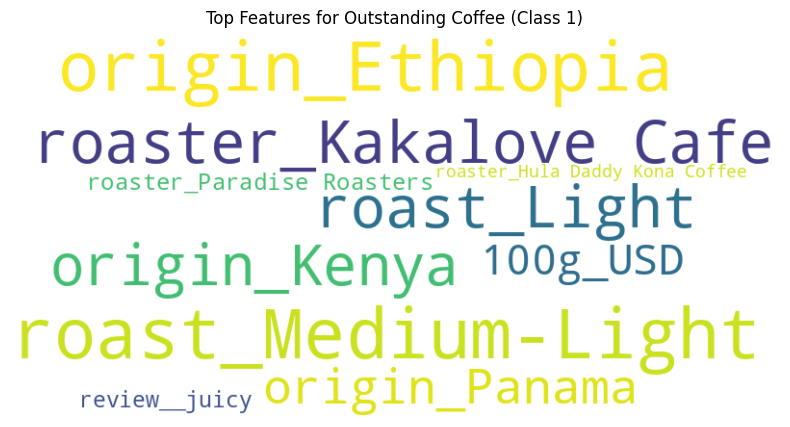

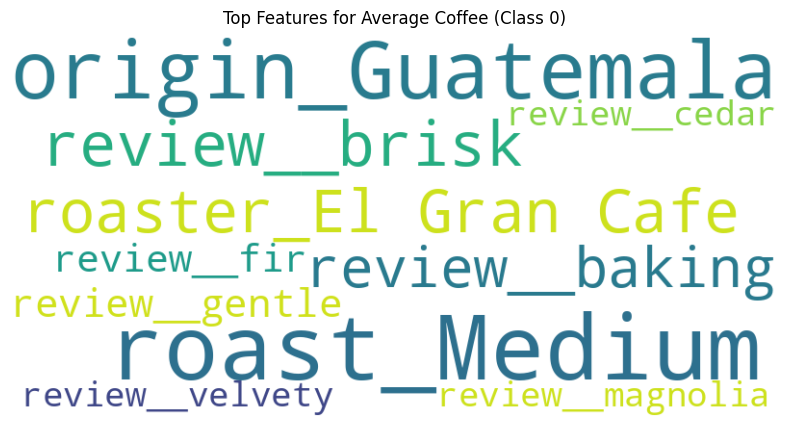

In [14]:
# Generate and display word clouds for top features
def generate_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=10)
    wordcloud.generate_from_frequencies(data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

class1_words = {feature: importance for feature, importance in sorted_features_class1[:10]}
class0_words = {feature: importance for feature, importance in sorted_features_class0[:10]}
generate_wordcloud(class1_words, "Top Features for Outstanding Coffee (Class 1)")
generate_wordcloud(class0_words, "Top Features for Average Coffee (Class 0)")